In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.externals import joblib
from scipy.sparse import hstack
%matplotlib inline

In [2]:
df_news = pd.read_csv('../data/news_headlines.csv')
df_news.publish_date = pd.to_datetime(df_news.publish_date, format='%Y%m%d')
df_news['publish_year'] = df_news.publish_date.dt.year
df_news.sort_values('publish_date', inplace=True)
print('Rows: {}'.format(df_news.shape[0]))
df_news.head()

Rows: 1000001


,publish_date,headline_text,publish_year
23668,2003-02-19,surge in new car sales in aust abs,2003
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003
8208,2003-02-19,nsw opp defends claims of running race campaign,2003
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003
20646,2003-02-19,sterrey to steer sharks,2003


### Checking for duplicates in dataset

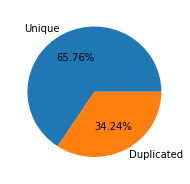

In [3]:
df_news.duplicated().map({True: 'Duplicated', False: 'Unique'}).value_counts().plot(
    kind='pie', autopct='%.2f%%', figsize=(3, 3), label='')

Example of duplicated

In [4]:
df_news.loc[df_news.headline_text == 'mans body found in river murray mannum']

,publish_date,headline_text,publish_year
968711,2017-07-03,mans body found in river murray mannum,2017
976437,2017-07-03,mans body found in river murray mannum,2017


In [5]:
df_news.drop_duplicates(inplace=True)

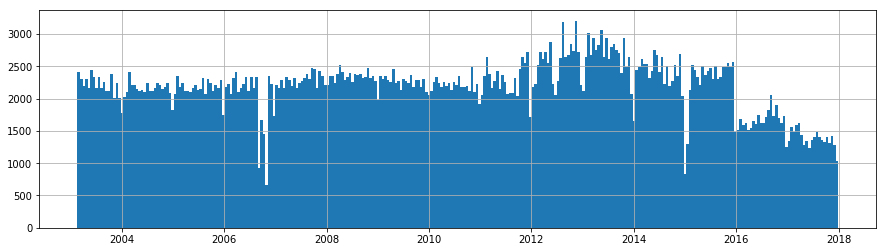

In [6]:
fig, ax = plt.subplots(figsize=(15,4))
df_news.publish_date.hist(ax=ax, bins=300);

# Pre processing text

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

def pre_processing(text):
    words = word_tokenize(text.lower(), language='english')
    words = [w for w in words if not w in stopwords]  # Remove stop words
    words = [w for w in words if not w in string.punctuation]  # Remove pontuacao
    words = [stemmer.stem(w) for w in words]  # Extrai radical da palavra
    return ' '.join(words)
def n_grams(text,n):
    words = word_tokenize(text.lower(), language='english')
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    words = ['-'.join(words[i]) for i in range(len(words))]
    return ' '.join(words)
def char_ngrams(text,n):
    words = ''.join(text.lower().split())
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    return ' '.join(words)



In [8]:
tic = time.time()

df_news['text'] = df_news.headline_text.apply(pre_processing)
df_news['2_grams'] = df_news.text.apply(lambda x: n_grams(x,2))
df_news['3_grams'] = df_news.text.apply(lambda x: n_grams(x,3))
df_news['4_chargrams'] = df_news.text.apply(lambda x: char_ngrams(x,4))

toc = time.time()
print('Elapsed time on text pre-processing: %d minutes and %d seconds.' % ((toc-tic)/60,(toc-tic)%60))
df_news.head()

Elapsed time on text pre-processing: 4 minutes and 59 seconds.


,publish_date,headline_text,publish_year,text,2_grams,3_grams,4_chargrams
23668,2003-02-19,surge in new car sales in aust abs,2003,surg new car sale aust ab,surg-new new-car car-sale sale-aust aust-ab,surg-new-car new-car-sale car-sale-aust sale-a...,surg urgn rgne gnew newc ewca wcar cars arsa r...
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003,new zealand impos visa entri zimbabw,new-zealand zealand-impos impos-visa visa-entr...,new-zealand-impos zealand-impos-visa impos-vis...,newz ewze wzea zeal eala alan land andi ndim d...
8208,2003-02-19,nsw opp defends claims of running race campaign,2003,nsw opp defend claim run race campaign,nsw-opp opp-defend defend-claim claim-run run-...,nsw-opp-defend opp-defend-claim defend-claim-r...,nswo swop wopp oppd ppde pdef defe efen fend e...
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003,qanta war plan cut 2500 job outrag union,qanta-war war-plan plan-cut cut-2500 2500-job ...,qanta-war-plan war-plan-cut plan-cut-2500 cut-...,qant anta ntaw tawa awar warp arpl rpla plan l...
20646,2003-02-19,sterrey to steer sharks,2003,sterrey steer shark,sterrey-steer steer-shark,sterrey-steer-shark,ster terr erre rrey reys eyst yste stee teer e...


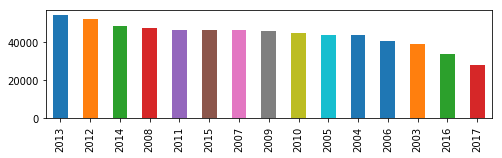

In [9]:
df_news.publish_year.value_counts().plot(kind='bar', figsize=(8, 2))

In [10]:
df_news.to_pickle('df_news.pkl')

# Feature extraction

### Using entire dataset:

In [11]:
from sklearn.externals import joblib

df_news = joblib.load('df_news.pkl')

In [12]:
df_news = df_news.reset_index().drop('index', axis=1)

In [13]:
sentences = df_news.headline_text.map(lambda x: x.split())

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(sentences, min_count=50,size=300,workers=4)

In [15]:
def invocab(sentence):
    x = []
    for i in range(len(sentence)):
        if(sentence[i] in model.wv.vocab.keys()):
            x.append(sentence[i])
    return x

In [16]:
texts = sentences.map(lambda x: invocab(x))

In [17]:
features = np.zeros((texts.shape[0],300))
for i,text in enumerate(texts):
    if len(text) != 0:
        feats = model.wv[text].sum(axis=0)
        features[i] = feats
    else:
        feats = np.zeros((300,))
        features[i] = feats

In [18]:
from sklearn.preprocessing import normalize

features = normalize(features)

In [19]:
joblib.dump(features,'features_.pkl')

['features_.pkl']

# Clustering:

In [20]:
features = joblib.load('features_.pkl')

In [21]:
def validity(model, N):
    intra = (model.inertia_ / N)
    centers = model.cluster_centers_
    flag = 1e10
    for i in range(centers.shape[0]):
        for j in range(i+1, centers.shape[0]):
            distance = paired_distances(centers[i].reshape(-1,1),centers[j].reshape(-1,1)).sum()
            if distance<flag:
                flag=distance
    inter = flag
    return intra/inter

### Estimating number of clusters:

In [22]:
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances
use_cache = True

inertias, scores, sils, val = [], [], [], []
n_clusters = range(2,31,1)
N = features.shape[0]
for n_cluster in n_clusters:
    tic = time.time()
    cluster_path = os.path.join('KMeans', 'KMeans_w2v_headline{}.pkl'.format(n_cluster))
    if not use_cache or not os.path.exists(cluster_path):
        cluster = KMeans(n_cluster, random_state=42, max_iter = 300, n_jobs=-1)
        cluster.fit(features)
        joblib.dump(cluster, cluster_path)
    else:
        cluster = joblib.load(cluster_path)
    inertias.append(cluster.inertia_)
    scores.append(cluster.score(features))  
    sils.append(silhouette_score(features, cluster.labels_, random_state=42, sample_size=5000))
    val.append(validity(cluster,N))
    print('Number of clusters: %d' % n_cluster)
    toc = time.time()
    print('Elapsed time: %d hours, %d minutes and %d seconds' % ((toc-tic)/3600,((toc-tic)/60)%60,(toc-tic)%60))


Number of clusters: 2
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 3
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 4
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 5
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 6
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 7
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 8
Elapsed time: 0 hours, 0 minutes and 1 seconds
Number of clusters: 9
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 10
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 11
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 12
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 13
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 14
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 15
Elapsed time: 0 hours, 0 minutes and 2 seconds
Number of clusters: 16
Elaps

In [23]:
import numpy as np

def plot(name, data, line_func=None):
    fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12, 5))
    ax.plot(n_clusters, data)
    if line_func:
        ax.axvline(n_clusters[line_func(data)], color='gray', alpha=0.3)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel(name)
    ax.set_title('Elbow method')
    plt.xticks(n_clusters)

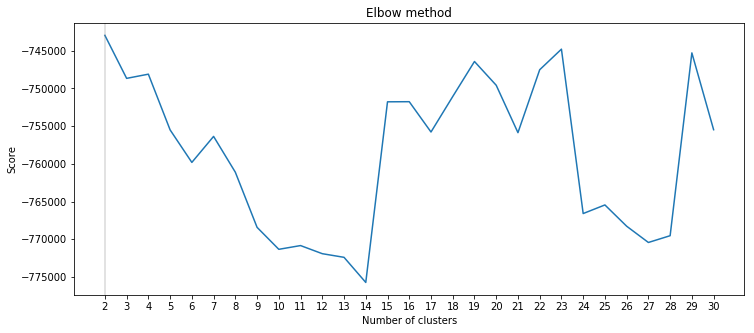

In [24]:
plot('Score', scores, np.argmax)

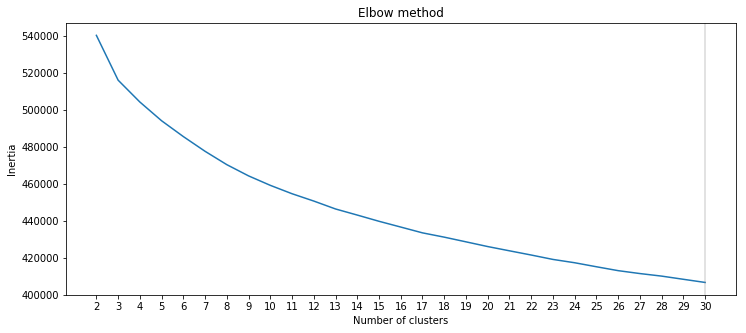

In [25]:
plot('Inertia', inertias, np.argmin)

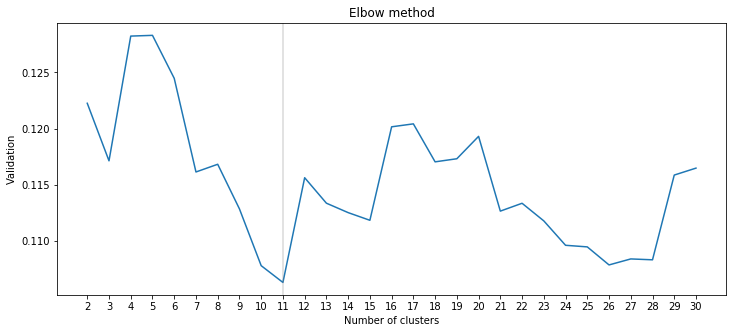

In [26]:
plot('Validation', val, np.argmin)

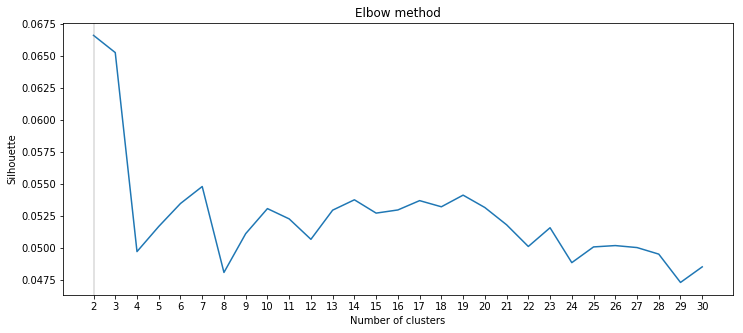

In [27]:
plot('Silhouette', sils, np.argmax)

In [28]:
print('Ideal number of clusters, based on silhouete and inertia analysis: 7')

Ideal number of clusters, based on silhouete and inertia analysis: 7


# Definition of label names

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def most_frequent(texts, n=10):
        counts = CountVectorizer(max_features=n, token_pattern=r'\w+-*\w+-*\w+')
        counts.fit_transform(texts)
        return [key for key in counts.vocabulary_]

In [30]:
cluster_path = "KMeans/KMeans_w2v_headline7.pkl"
cluster = joblib.load(cluster_path)
features = joblib.load('features_.pkl')

In [31]:
df_news['cluster'] = cluster.predict(features)

#### Cluster 0:

In [32]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==0].head(10))

Top 10 words:
['speak', 'call', 'john', 'interview', 'extend', 'guilti', 'michael', 'media', 'plead', 'andrew']


Top 10 2-grams:
['interview-john', 'interview-david', 'media-call', 'interview-michael', 'extend-interview', 'interview-jame', 'interview-andrew', 'plead-guilti', 'interview-chris', 'interview-ben']


Top 10 3-grams:
['steven-schubert-speak', 'interview-shane-flanagan', 'interview-des-hasler', 'interview-trent-robinson', 'interview-ivan-cleari', 'interview-michael-maguir', 'interview-david-furner', 'belinda-varischetti-interview', 'interview-john-cartwright', 'interview-geoff-toovey']


10 examples of headines:
845                           drowned fishermen named
890              east timor seeks help to try wiranto
1077                        petitions oppose brothels
1324      minister asks retailers to stand by produce
1513               ama backs heroin trial for addicts
1657            nsw dpp supports limited heroin trial
1702    northern tablelands candidate pays tr

A label for this cluster group is: X

#### Cluster 1:

In [33]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==1].head(10))

Top 10 words:
['day', 'year', 'call', 'plan', 'australia', 'australian', 'first', 'report', 'market', 'new']


Top 10 2-grams:
['sri-lanka', 'world-cup', 'rural-news', 'new-zealand', 'abc-busi', 'nation-rural', 'share-market', 'hour-podcast', 'climat-chang', 'countri-hour']


Top 10 3-grams:
['busi-news-market', 'tas-countri-hour', 'nsw-countri-hour', 'nation-rural-news', 'news-market-analysi', 'wa-countri-hour', 'countri-hour-podcast', 'vic-countri-hour', 'rural-qld-podcast', 'abc-busi-news']


10 examples of headines:
1           new zealand imposes visa entry for zimbabwe
10            six palestinians killed in gaza incursion
14    aussie qualifier stosur wastes four memphis match
20                  orientation begins for uni students
23          nth koreans seek asylum at japanese embassy
26             bushfire victims urged to see centrelink
34               community urged to help homeless youth
36                   nsw opp pledges 50m drought relief
42             pienaar shi

A label for this cluster group is: <b>X</b>

#### Cluster 2:

In [34]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==2].head(10))

Top 10 words:
['court', 'accus', 'man', 'charg', 'face', 'men', 'trial', 'murder', 'stab', 'polic']


Top 10 2-grams:
['guilti-plea', 'man-charg', 'murder-charg', 'face-trial', 'man-face', 'face-court', 'polic-charg', 'remand-custodi', 'charg-laid', 'two-men']


Top 10 3-grams:
['man-face-court', 'attempt-murder-charg', 'alleg-peopl-smuggler', 'gang-rape-accus', 'face-murder-charg', 'child-sex-charg', 'murder-accus-face', 'pair-face-trial', 'accus-remand-custodi', 'accus-face-trial']


10 examples of headines:
408     brothel owner fronts court after allegedly hiring
1090             police prepare case over stabbing charge
1300      man allowed to appeal against murder conviction
2120            five sent to trial over sydney gang rapes
2721     police charge 10 teenagers after brawl at sydney
2848        us girl found nine months after disappearance
3002                   manhunt after shooting in adelaide
3081         court to decide on bail for sex case accused
3193               p

A label for this cluster group is: <b>X</b>

#### Cluster 3:

In [35]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==3].head(10))

Top 10 words:
['council', 'man', 'fire', 'plan', 'polic', 'win', 'say', 'govt', 'back', 'new']


Top 10 2-grams:
['polic-investig', 'car-crash', 'asylum-seeker', 'broken-hill', 'man-die', 'gold-coast', 'face-court', 'govt-urg', 'rate-rise', 'plead-guilti']


Top 10 3-grams:
['get-green-light', 'nation-press-club', 'man-plead-guilti', 'far-north-qld', 'one-plus-one', 'man-face-court', 'great-barrier-reef', 'man-front-court', 'mid-north-coast', 'front-court-accus']


10 examples of headines:
0                   surge in new car sales in aust abs
2      nsw opp defends claims of running race campaign
3     qantas war plan to cut 2500 jobs outrages unions
4                              sterrey to steer sharks
6            worksafe probes potato harvester injuries
7               more women urged to become councillors
8                 teen to face court over drug charges
9     unions to ask members to support public protests
11                          bathhouse plans move ahead
12        

A label for this cluster group is: <b>X</b>

#### Cluster 4:

In [36]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==4].head(10))

Top 10 words:
['urg', 'two', 'say', 'attack', 'home', 'continu', 'open', 'former', 'claim', 'lead']


Top 10 2-grams:
['wild-oat', 'islam-state', 'australian-open', 'gay-marriag', 'plead-guilti', 'wild-dog', 'vow-fight', 'open-lead', 'al-qaeda', 'us-open']


Top 10 3-grams:
['man-plead-guilti', 'guilti-child-sex', 'wild-oat-xi', 'plead-guilti-child', 'ban-two-match', 'child-sex-charg', 'plead-guilti-murder', 'al-qaeda-suspect', 'al-qaeda-claim', 'al-qaeda-link']


10 examples of headines:
117             mugabe to touch down in paris for summit
118          injured rios pulls out of buenos aires open
127       brigadier dismisses reports troops harassed in
141    deportivo slip against buoyant swiss minnows b...
144         more than 60 detained after immigration raid
248                        etienne agrees to tyson fight
276           aek shut out malaga to claim goalless draw
295    telstra punished after massive hong kong write...
346                   funk leads elkington in cali

A label for this cluster group is: <b>X</b>

#### Cluster 5:

In [37]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==5].head(10))

Top 10 words:
['jail', 'age', 'prison', 'charg', 'drop', 'former', 'dead', 'top', 'kill', 'die']


Top 10 2-grams:
['take-charg', 'die-age', 'kill-shoot', 'hundr-kill', 'drug-charg', 'charg-drop', 'year-jail', 'rebel-leader', 'age-74', 'drop-charg']


Top 10 3-grams:
['die-age-89', 'die-age-81', 'die-age-107', 'die-age-90', 'die-age-69', 'die-age-76', 'die-age-74', 'die-age-86', 'die-age-85', 'die-age-95']


10 examples of headines:
3789                              wwi digger dies aged 104
4498                       hundreds killed in najaf battle
5033                    aust playwright enright dies at 52
5382     bolivia mudslide kills 14 400 feared buried alive
6335                kurdish forces seize towns near kirkuk
7956                               yze cleared at tribunal
8618              ivory coast rebel chief killed in ambush
9616                  former apartheid fighter sisulu dies
11731    church employee warned against raising suspicions
12999                fremantle p

A label for this cluster group is: <b>X</b>

#### Cluster 6:

In [38]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==6], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==6], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==6], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==6].head(10))

Top 10 words:
['jail', 'man', 'court', 'polic', 'woman', 'charg', 'murder', 'death', 'miss', 'kill']


Top 10 2-grams:
['car-crash', 'man-jail', 'man-arrest', 'refus-bail', 'polic-probe', 'murder-trial', 'search-miss', 'man-charg', 'bodi-found', 'face-court']


Top 10 3-grams:
['child-sex-offenc', 'charg-attempt-murder', 'man-charg-murder', 'polic-search-miss', 'search-continu-miss', 'fatal-car-crash', 'man-face-court', 's-death', 'man-front-court', 'car-bomb-kill']


10 examples of headines:
5                   refshauge wins defamation court case
27            police defend aboriginal tent embassy raid
35       search continues for victims in s korean subway
78       german court to give verdict on sept 11 accused
86                 irish man arrested over omagh bombing
95                         snowtown murder trial delayed
99     investigations underway into death toll of korean
103              jury to consider verdict in murder case
106             nca defends aboriginal tent em

A label for this cluster group is: <b>X</b>